In [32]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
# import spacy
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

In [191]:
import tensorflow as tf
print(tf.__version__)


2.12.0


In [61]:
nlp = spacy.load("en_core_web_sm")

/Users/jaredperez/opt/miniconda3/envs/flask_blog/lib/python3.10/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
%store -r DTR_training_data
%store -r names

In [192]:
DTR_training_data

array([['Masha', 'Banded walks', '3', '3', '1'],
       ['Masha', 'Clam Shells', '3', '3', '30'],
       ['Masha', 'Abductions', '3', '3', '30'],
       ...,
       ['Masha', 'Hammy Planks', '1', '1', '1'],
       ['Masha', 'Piegon Pose', '1', '1', '1'],
       ['Masha', 'Frog or Butterfly', '1', '1', '1']], dtype='<U36')

In [3]:
def convert_to_int(arr):
    try:
        return np.array([int(float(elem)) for elem in arr], dtype=int)
    except ValueError:
        return None

In [4]:
int_var=[]
variables=DTR_training_data[:,2:]
for i, arr in enumerate(variables):
        converted_arr = convert_to_int(arr)
        if converted_arr is not None:
            int_var.append(converted_arr)

In [5]:
df=pd.DataFrame(DTR_training_data)
df=df.drop(columns=[2,3,4])

variables=pd.DataFrame(int_var)
variables.columns=['Weight', 'Sets', 'Reps']
df=pd.concat([df, variables], axis=1)

df['VL'] = df['Weight'].mul(df['Sets']).mul(df['Reps'])
df.columns=['Name', 'Exercise', 'Weight', 'Sets', 'Reps', 'VL']

In [7]:
volume_loads=df['VL']
exercises=df['Exercise']

In [22]:
scaled_VL=MinMaxScaler().fit_transform(df['VL'].to_numpy().reshape(-1,1))
scaled_VL

array([[4.28571429e-04],
       [1.28571429e-02],
       [1.28571429e-02],
       ...,
       [4.76190476e-05],
       [4.76190476e-05],
       [4.76190476e-05]])

In [165]:
def get_intensity_range(intensity):
    if intensity.lower() == 'light':
        return 0, 0.33
    elif intensity.lower() == 'moderate':
        return 0.33, 0.66
    elif intensity.lower() == 'heavy':
        return 0.66, 1
    else:
        raise ValueError("Invalid intensity value")


In [8]:
def get_weight(node1, node2, volume_loads, exercises):
    exercise_to_volume_load = {}
    for exercise, volume_load in zip(exercises, volume_loads):
        if exercise not in exercise_to_volume_load:
            exercise_to_volume_load[exercise] = []
        exercise_to_volume_load[exercise].append(volume_load)

    # Remove duplicates from the lists of volume loads
    for exercise in exercise_to_volume_load:
        exercise_to_volume_load[exercise] = list(set(exercise_to_volume_load[exercise]))

    weighted_avg_dict = {}
    for exercise, weights in exercise_to_volume_load.items():
        average_weight = sum(weights) / len(weights)
        weighted_avg_dict[exercise] = average_weight

    return weighted_avg_dict.get(node1, 0) + weighted_avg_dict.get(node2, 0)


## Lets fix this function later to accept a list of parameters due to its high specificty

In [87]:
def filter_exercises_by_keyword(exercises, keyword):
    keyword_lemma = nlp(keyword)[0].lemma_.lower()
    filtered_exercises = []

    for exercise in exercises:
        exercise_tokens = nlp(exercise)
        for token in exercise_tokens:
            if token.lemma_.lower() == keyword_lemma:
                filtered_exercises.append(exercise)
                break
                
    filtered_exercises=np.unique(filtered_exercises)

    return filtered_exercises


In [89]:
filter_exercises_by_keyword(df['Exercise'], 'Bench')

array(['BB Bench Press', 'BB Incline Bench Press', 'Bench Dips',
       'Bench Pushup', 'Bench Pushups', 'DB Bench Press',
       'DB Incline Bench Press', 'SA DB Bench Press'], dtype='<U22')

In [271]:
def build_workout(training_data, intensity=None, name=None, keyword=None, num_exercises=None):
    if name is not None:
        training_data=training_data[training_data['Name']==name]
        
    exercises=training_data['Exercise'][:200]
    volume_loads=training_data['VL'][:200]
    
    if keyword:
        nodes = filter_exercises_by_keyword(exercises, keyword)
    else:
        nodes = exercises

    # Create the graph and add the edges with weights
    G = nx.Graph()
    for i, node1 in enumerate(nodes):
        for node2 in nodes[i+1:]:
            weight = get_weight(node1, node2, volume_loads, exercises)
            G.add_edge(node1, node2, weight=weight)

    # Generate a workout by traversing the graph
    workout = []
    start_node = random.choice(nodes)
    current_node = start_node
    visited_nodes = set()
    if num_exercises is None:
        num_exercises=7
    while len(workout) < num_exercises:  # Generate a workout with 5 exercises
        visited_nodes.add(current_node)
        neighbors = list(G.neighbors(current_node))
        unvisited_neighbors = [n for n in neighbors if n not in visited_nodes]
        if len(unvisited_neighbors) == 0:  # No more neighbors to visit
            break
        neighbor_weights = [G[current_node][neighbor]['weight'] for neighbor in unvisited_neighbors]

        # Check if the total weight of the unvisited neighbors is greater than zero
        if sum(neighbor_weights) <= 0:
            break

        if len(neighbor_weights) == 0:  # All neighbors have been visited
            start_node = random.choice(list(set(nodes) - visited_nodes))
            current_node = start_node
            continue

        next_node = random.choices(unvisited_neighbors, weights=neighbor_weights)[0]
        workout.append(next_node)
        current_node = next_node
        
    # Print the generated workout
    print("Generated workout:")
    for i, exercise in enumerate(workout):
        print(f"{i+1}. {exercise}")


In [272]:
build_workout(df, 'light')

Generated workout:
1. Squat Thrusters
2. SA DB Row
3. Clam Shells
4. SA Curl to OH Press
5. Db Swings
6. LB Warm Up
7. SL Glute Bridges


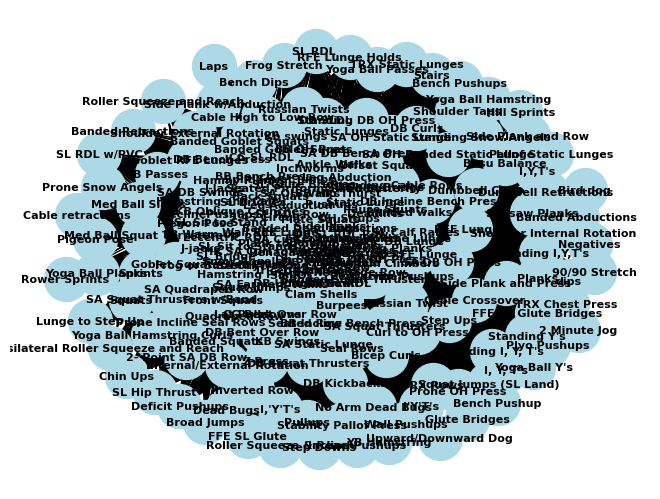

In [269]:
# Draw the graph
nx.draw(G, with_labels=True, node_color='lightblue', font_size=8, font_weight='bold', node_size=1000)

# Display the plot
plt.show()

### This approach can work except for the fact that it takes literally over 20 minutes to develop the network graph when all the exercises are included. It is completley unrealistic

There is also no good way to include the intensity, it seems to just break when I include an intensity


Going to switch to using a word embedding and autoencoder approach, probably still overkill, but I will start at tf and scale backwards

In [8]:
import gensim.downloader as api

In [9]:
from gensim.test.utils import datapath
from gensim import utils

In [10]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __iter__(self):
        corpus_path = datapath('lee_background.cor')
        for line in open(corpus_path):
            # assume there's one document per line, tokens separated by whitespace
            yield utils.simple_preprocess(line)

Had to modify the exercises list due to I,Y,T's embeddings. Check a few cells down and rerun

In [44]:
non_101=[]
for i, arr in enumerate(input_data):
    if arr.shape != (101,):
        print(i)
        non_101.append(i)

(101,)

In [197]:
df[df['Exercise']=="I'Y'T's"]

,Name,Exercise,Weight,Sets,Reps,VL


In [198]:
non_101

[1401,
 1466,
 1490,
 1589,
 1608,
 1730,
 1777,
 1822,
 1846,
 1894,
 1899,
 1907,
 1992,
 2035,
 2044,
 2094,
 2101,
 2211]

In [53]:
exercises[non_101]='eyes, whys, and tees'
exercises[non_101]

1401    eyes, whys, and tees
1466    eyes, whys, and tees
1490    eyes, whys, and tees
1589    eyes, whys, and tees
1608    eyes, whys, and tees
1730    eyes, whys, and tees
1777    eyes, whys, and tees
1822    eyes, whys, and tees
1846    eyes, whys, and tees
1894    eyes, whys, and tees
1899    eyes, whys, and tees
1907    eyes, whys, and tees
1992    eyes, whys, and tees
2035    eyes, whys, and tees
2044    eyes, whys, and tees
2094    eyes, whys, and tees
2101    eyes, whys, and tees
2211    eyes, whys, and tees
Name: Exercise, dtype: object

In [55]:
test=exercises.to_numpy()

In [56]:
class MyCorpus:
    """An iterator that yields sentences (lists of str)."""

    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for document in self.documents:
            # assume there's one document per element in the list, tokens separated by whitespace
            yield utils.simple_preprocess(document)

# Example usage
documents = [
    "This is the first document.",
    "This is the second document.",
    "And this is the third one.",
]

corpus = MyCorpus(test)
for tokens in corpus:
    print(tokens)


['banded', 'walks']
['clam', 'shells']
['abductions']
['squat', 'thrusters']
['sl', 'bridges']
['squat', 'thrusters']
['static', 'db', 'lunge']
['sl', 'rdl']
['sl', 'bridges']
['hamstring', 'plank']
['bicycles']
['banded', 'walks']
['squat', 'thrusters']
['sl', 'rdl']
['clam', 'shells']
['abductions']
['static', 'db', 'lunge']
['squat', 'thrusters']
['renagade', 'row']
['static', 'db', 'lunge']
['sl', 'sit', 'to', 'stand']
['banded', 'squat', 'thrusters']
['static', 'db', 'lunge']
['sl', 'sit', 'to', 'stand']
['plate', 'squats']
['sa', 'oh', 'walking', 'lunge']
['eccentric', 'rdl']
['sl', 'bridge']
['mountain', 'climbers']
['plate', 'squats']
['sa', 'oh', 'walking', 'lunge']
['sl', 'rdl']
['jacks']
['db', 'squats']
['db', 'swings']
['declinepushups']
['db', 'pullover']
['side', 'planks']
['decline', 'pushups']
['db', 'squat']
['goblet', 'squat']
['rfe', 'lunge']
['hk', 'sa', 'db', 'oh', 'press']
['rdl']
['bent', 'over']
['tricep', 'kickbacks']
['db', 'swings']
['db', 'oh', 'press']
['d

In [57]:
tokens=[token for token in MyCorpus(test)]

In [15]:
import gensim

In [58]:
corpus_instance = MyCorpus(test)
model = gensim.models.Word2Vec(vector_size=100, window=5, min_count=1, workers=4)

# Build vocabulary from the corpus
model.build_vocab(corpus_instance)

# Train the model on the corpus
model.train(corpus_instance, total_examples=model.corpus_count, epochs=10)

(24745, 59240)

In [59]:
model.wv['lunges']

array([ 0.00723348,  0.03965259,  0.01028035, -0.00308409,  0.00357362,
       -0.06955039,  0.025717  ,  0.06040769, -0.03647047, -0.04694229,
       -0.00329748, -0.04956691, -0.01275303,  0.01204215,  0.03832851,
        0.00136958, -0.0012598 , -0.04609459, -0.00467737, -0.10850739,
        0.03776117,  0.03238377,  0.00947715, -0.01686266, -0.01588939,
        0.01118057, -0.05067747,  0.00415493, -0.01299512, -0.00271463,
        0.04185777, -0.00328386,  0.03855478, -0.04883177, -0.03080935,
        0.04394603,  0.02021905,  0.0058675 , -0.00410073, -0.06606884,
        0.04732373, -0.01810756, -0.04459989, -0.01568447,  0.03246703,
       -0.02062979, -0.04652987, -0.00836342,  0.05801927,  0.02205637,
       -0.01375121, -0.01173977,  0.02804346, -0.00632683,  0.01966232,
        0.01413928,  0.00988748,  0.02128881, -0.00720899,  0.00651313,
       -0.00477609,  0.00732351,  0.03855246, -0.01234503, -0.06999767,
        0.06204348,  0.03442809,  0.02953202, -0.05040561,  0.07

In [60]:
exercise_vectors = []

for exercise in tokens:
    exercise_vector = np.mean([model.wv[word] for word in exercise], axis=0)
    exercise_vectors.append(exercise_vector)


In [194]:
tokens

[['banded', 'walks'],
 ['clam', 'shells'],
 ['abductions'],
 ['squat', 'thrusters'],
 ['sl', 'bridges'],
 ['squat', 'thrusters'],
 ['static', 'db', 'lunge'],
 ['sl', 'rdl'],
 ['sl', 'bridges'],
 ['hamstring', 'plank'],
 ['bicycles'],
 ['banded', 'walks'],
 ['squat', 'thrusters'],
 ['sl', 'rdl'],
 ['clam', 'shells'],
 ['abductions'],
 ['static', 'db', 'lunge'],
 ['squat', 'thrusters'],
 ['renagade', 'row'],
 ['static', 'db', 'lunge'],
 ['sl', 'sit', 'to', 'stand'],
 ['banded', 'squat', 'thrusters'],
 ['static', 'db', 'lunge'],
 ['sl', 'sit', 'to', 'stand'],
 ['plate', 'squats'],
 ['sa', 'oh', 'walking', 'lunge'],
 ['eccentric', 'rdl'],
 ['sl', 'bridge'],
 ['mountain', 'climbers'],
 ['plate', 'squats'],
 ['sa', 'oh', 'walking', 'lunge'],
 ['sl', 'rdl'],
 ['jacks'],
 ['db', 'squats'],
 ['db', 'swings'],
 ['declinepushups'],
 ['db', 'pullover'],
 ['side', 'planks'],
 ['decline', 'pushups'],
 ['db', 'squat'],
 ['goblet', 'squat'],
 ['rfe', 'lunge'],
 ['hk', 'sa', 'db', 'oh', 'press'],
 ['rd

In [61]:
len(exercise_vectors)

2437

## Combining the word embeddings with volume load values

In [62]:
# Normalize volume load values...done above
len(scaled_VL)

2437

In [63]:
len(exercise_vectors)

2437

## Within input_data the string embeddings and the volume load are paired, which means I need to know the indexes for unique exercises with the corresponding VL and which one is higher/lower so later on in my function for getting related exercises, it can select related exercises that are ALSO related by volume load


for example 

idx0 is squats: light vl

idx1 is squats: moderate vl

idx2 is lunges: light vl

idx3 is lunges: moderate vl


By knowing which index corresponds to a max/min VL that has been prescribed, when a user inputs an exercise and then a subseqeunt intensity, the model will look for semantic relaitonships (similar exercises) and will always pull up the same similar exercises (presumably) but by extracting the one at the correct index for the corresponding VL it will pull exercises that are similarly loaded (presumably

In [99]:
input_data

array([[ 1.5890352e-02,  7.7257417e-02, -2.2101263e-04, ...,
         5.2752090e-03, -1.3517275e-02,  4.2857142e-04],
       [ 1.2655124e-02,  2.9573441e-02,  3.5400796e-03, ...,
         1.1735845e-02, -2.5109226e-02,  1.2857143e-02],
       [ 5.3717266e-03, -9.5871987e-04, -4.2395294e-03, ...,
         1.0194905e-02, -2.3711775e-03,  1.2857143e-02],
       ...,
       [ 2.4551053e-03,  4.9392730e-02,  5.6781610e-03, ...,
         1.4139853e-02, -8.0484943e-03,  4.7619047e-05],
       [ 1.6544743e-02,  8.3389044e-02,  5.9437347e-03, ...,
         1.8026344e-02, -3.2339945e-02,  4.7619047e-05],
       [ 2.7685277e-02,  1.2866877e-01,  3.8393799e-03, ...,
         2.8981132e-02, -4.6824705e-02,  4.7619047e-05]], dtype=float32)

In [64]:
# Combine exercise vectors with volume loads
input_data = []
for exercise_vector, volume_load_normalized in zip(exercise_vectors, scaled_VL):
    combined = np.hstack((exercise_vector, volume_load_normalized))
    input_data.append(combined)
input_data = np.array(input_data)


input_data=np.array(input_data, dtype=np.float32)

## Using tf autoencoder

In [65]:
input_data.shape
input_data=np.array(input_data, dtype=np.float32)

In [69]:
input_data[0].shape

(101,)

In [71]:
input_size = input_data[0].shape[0]
encoding_dim = 32  # You can choose the size of the encoding

# Create the autoencoder model
input_layer = Input(shape=(input_size,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_size, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)

# Create the encoder model (to get the compact representation)
encoder = Model(input_layer, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(input_data, input_data, epochs=100, batch_size=32, shuffle=True)


Epoch 1/100
77/77 [==============================] - 1s 5ms/step - loss: 0.1954
Epoch 2/100
77/77 [==============================] - 0s 4ms/step - loss: 0.0406
Epoch 3/100
77/77 [==============================] - 0s 4ms/step - loss: 0.0149
Epoch 4/100
77/77 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 5/100
77/77 [==============================] - 0s 4ms/step - loss: 0.0080
Epoch 6/100
77/77 [==============================] - 0s 4ms/step - loss: 0.0065
Epoch 7/100
77/77 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 8/100
77/77 [==============================] - 0s 4ms/step - loss: 0.0048
Epoch 9/100
77/77 [==============================] - 0s 4ms/step - loss: 0.0044
Epoch 10/100
77/77 [==============================] - 0s 4ms/step - loss: 0.0041
Epoch 11/100
77/77 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 12/100
77/77 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 13/100
77/77 [=================

## Saving model after finishing testing

In [193]:
# Save the model to a file
autoencoder.save('autoencoder_exercise_selector.h5')


In [200]:
encoder.save('encoder_exercise_selector.h5')

In [72]:
# Get the compact representation
encoded_exercises = encoder.predict(input_data)

77/77 [==============================] - 0s 913us/step


In [73]:
encoded_exercises

array([[0.8609562 , 1.7510213 , 0.9590234 , ..., 1.0026492 , 0.7500215 ,
        0.8496437 ],
       [0.68379796, 1.1167637 , 0.7293668 , ..., 0.75885606, 1.105738  ,
        0.6538176 ],
       [0.4307544 , 0.0467118 , 0.32824743, ..., 0.36882138, 1.6318725 ,
        0.33359176],
       ...,
       [0.6979021 , 1.1707267 , 0.7466468 , ..., 0.77815354, 1.0122914 ,
        0.684724  ],
       [0.93308526, 2.079808  , 1.0801202 , ..., 1.1320227 , 0.67374706,
        0.9515224 ],
       [1.2775879 , 3.3118036 , 1.5553315 , ..., 1.5963444 , 0.14313412,
        1.3359747 ]], dtype=float32)

In [74]:
from sklearn.metrics.pairwise import cosine_similarity

In [75]:
# Calculate the similarity matrix
similarity_matrix = cosine_similarity(encoded_exercises)

In [92]:
similarity_matrix[0]

array([1.        , 0.9851508 , 0.78860396, ..., 0.9898274 , 0.99879646,
       0.98182434], dtype=float32)

In [120]:
def find_similar_exercises(exercise_index, exercises, similarity_matrix, top_n=5):
    # Get the similarity scores for the given exercise
    similarity_scores = similarity_matrix[exercise_index]

    # Sort the similarity scores and get the indices
    sorted_indices = np.argsort(similarity_scores)[::-1]

    # Exclude exercises with the same string value as the original exercise
    original_exercise = exercises[exercise_index]
    unique_indices = [idx for idx in sorted_indices if exercises[idx] != original_exercise]

    # Find top_n unique exercises
    top_n_indices = []
    unique_exercises = set()
    for idx in unique_indices:
        if exercises[idx] not in unique_exercises:
            unique_exercises.add(exercises[idx])
            top_n_indices.append(idx)
            if len(top_n_indices) >= top_n:
                break

    # Return the indices of the top n most similar unique exercises
    return top_n_indices





# Example usage:
exercise_index = 1528
top_n = 5
similar_exercise_indices = find_similar_exercises(exercise_index, exercises, similarity_matrix, top_n)

In [134]:
exercises[exercises=='Goblet Squats'].index[0]

1787

In [135]:
exercise=input('Exercise: ')
exercise_index=exercises[exercises==exercise].index[0]
top_n = 5
similar_exercise_indices = find_similar_exercises(exercise_index, exercises, similarity_matrix, top_n)

Exercise: Back Squats


In [150]:
print("Most similar exercise indices:", similar_exercise_indices)

# Print the original exercise and the most similar exercises
print("Original exercise:", exercises[exercise_index])
print("Similarity Scores: ", scores)
print("Most similar exercises:")
for index in similar_exercise_indices:
    print(exercises[index], volume_loads[index])


Most similar exercise indices: [1794, 2172, 649, 1527, 2041]
Original exercise: Back Squats
Similarity Scores:  [0.9954082  0.96450645 0.72676045 ... 0.97188336 0.9988554  0.99538404]
Most similar exercises:
Goblet Squats 900
YB Passes 540
Plate Squats 480
Goblet Squat 675
Dumbbell Curls 360


In [109]:
options=df[df['Exercise']=='SA OH Walking Lunge']

In [189]:
def volume_load_from_scaled(index, input_data, scaler):
    volume_load_normalized = input_data[index][-1]

    volume_load_original = scaler.inverse_transform(volume_load_normalized.reshape(-1, 1))[0][0]

    return volume_load_original


In [140]:
scaler=MinMaxScaler().fit(df['VL'].to_numpy().reshape(-1,1))

In [147]:
scaler.inverse_transform(scaled_VL)

array([[  9.],
       [270.],
       [270.],
       ...,
       [  1.],
       [  1.],
       [  1.]])

In [149]:
get_volume_load(0, input_data, scaler)

9.0

In [156]:
quantile_value

175.9999999999999

In [158]:
quantile_value = df[df['Exercise'] == 'RFE Lunges']['VL'].quantile(1/4)
filtered_df = df[(df['Exercise'] == 'RFE Lunges') & (df['VL'] <= quantile_value)].sort_values(by='VL')
filtered_df

,Name,Exercise,Weight,Sets,Reps,VL
1521,Misha,RFE Lunges,1,1,12,12
1909,Dimitri,RFE Lunges,1,2,10,20
1957,Misha,RFE Lunges,1,3,8,24
2021,Yelena,RFE Lunges,1,3,8,24
1417,Misha,RFE Lunges,1,3,10,30
1551,Nat,RFE Lunges,1,3,10,30
2054,Abelev,RFE Lunges,1,3,10,30
2270,Mary,RFE Lunges,1,3,10,30
1754,Misha,RFE Lunges,1,3,15,45
2224,Nick,RFE Lunges,1,3,15,45


In [169]:
def get_intensity_range(exercise_options_df, intensity):
    if intensity.lower() == 'light':
        quantile_value = exercise_options_df['VL'].quantile(1/4)
        filtered_options = exercise_options_df[exercise_options_df['VL'] <= quantile_value].sort_values(by='VL')
        return filtered_options['VL']
    elif intensity.lower() == 'moderate':
        quantile_value_lower = exercise_options_df['VL'].quantile(1/4)
        quantile_value_upper = exercise_options_df['VL'].quantile(3/4)
        filtered_options = exercise_options_df[(exercise_options_df['VL'] > quantile_value_lower) & 
                                               (exercise_options_df['VL'] <= quantile_value_upper)].sort_values(by='VL')
        return filtered_options['VL']
    elif intensity.lower() == 'heavy':
        quantile_value = exercise_options_df['VL'].quantile(3/4)
        filtered_options = exercise_options_df[exercise_options_df['VL'] > quantile_value].sort_values(by='VL')
        return filtered_options['VL']
    else:
        raise ValueError("Invalid intensity value")


In [173]:
test=get_intensity_range(test, 'heavy')

In [174]:
random.choice(test.index)

1788

In [180]:
df[df['Exercise']=='BB Hip Thurst']

,Name,Exercise,Weight,Sets,Reps,VL
1628,Yelena,BB Hip Thurst,85,3,10,2550
1649,Yelena,BB Hip Thurst,115,3,8,2760
1924,Yelena,BB Hip Thurst,80,3,8,1920
2126,Yelena,BB Hip Thurst,95,4,5,1900
2151,Yelena,BB Hip Thurst,105,4,5,2100


In [190]:
exercise=input('Exercise: ')
intensity=input('Intensity: ')
exercise_options=df[df['Exercise']==exercise]
VL_range=get_intensity_range(exercise_options, intensity)
exercise_index=random.choice(VL_range.index)
top_n = 5
similar_exercise_indices = find_similar_exercises(exercise_index, exercises, similarity_matrix, top_n)
# volume_loads=get_volume_load(exercise_index, input_data, scaler)


# Print the original exercise and the most similar exercises
print("Original exercise:", exercises[exercise_index])
print("Most similar exercises:")
for index in similar_exercise_indices:
    print(exercises[index], volume_loads[index])


Exercise: RDL
Intensity: light
Original exercise: RDL
Most similar exercises:
Banded Abductions 30
Pallof Static Lunges 30
Broad Jumps 36
Cable retractions 30
Rower Sprints 30
